# This is used to reweight the quasar catalogue using DESI code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp
import seaborn as sns
from imsys_fitter import Syst

In [17]:
# data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
maps = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')

In [4]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [20]:
Rg = 3.793                                      # from 2002AJ....123..485S table 22
def get_property_map(ra, dec):
    pix = hp.ang2pix(Nside, np.deg2rad(90 - dec), np.deg2rad(ra))
    data = {}
    data['EBV'] = maps['EBV'][pix]
    data['DEPTH_G'] = 22.5 - 2.5*np.log10(maps['DEPTH_G'][pix]) - Rg*data['EBV']
    data['SKY_I'] = maps['SKY_I'][pix]
    data['PSF_I'] = maps['PSF_I'][pix]
    return data

In [22]:
def reweight(quasar_cata, random_cata):
    data_q = get_property_map(quasar_cata['RA'], quasar_cata['DEC'])
    data_r = get_property_map(random_cata['RA'], random_cata['DEC'])

    analyzer = Syst(quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'], random_cata['WEIGHT_FKP'])
    for k in data_q.keys():
        analyzer.add_syst(k, data_q[k], data_r[k])
    analyzer.cut_outliers(p=1)
    analyzer.prepare()
    analyzer.fit_minuit()
    result = dict(zip(analyzer.par_names, analyzer.best_pars))
    weight_model = 1/analyzer.get_model(result, data_q)
    return weight_model

In [ ]:
def refine_catalogue(quasar):
    quasar_cata = np.zeros(len(quasar), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
    quasar_cata['ra'] = quasar['RA']
    quasar_cata['dec'] = quasar['DEC']
    quasar_cata['z'] = quasar['Z']
    quasar_cata['w'] = quasar['WEIGHT_SYSTOT']*quasar['WEIGHT_NOZ']*quasar['WEIGHT_CP']*quasar_cata['WEIGHT_FKP']
    return quasar_cata

In [26]:
quasar_n['WEIGHT_SYSTOT'] = reweight(quasar_n, random_n)
quasar_s['WEIGHT_SYSTOT'] = reweight(quasar_s, random_s)
quasar_all = np.hstack((quasar_n, quasar_s))

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 646.54   ndata = 40                rchi2 = 16.1634
chi2 (after  fit) = 73.86   ndata = 40   npars = 5   rchi2 = 2.1104
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 1505.26   ndata = 40                rchi2 = 37.6314
chi2 (after  fit) = 24.87   ndata = 40   npars = 5   rchi2 = 0.7106


In [27]:
np.save('../catalogue/quasar_lss_reweight', refine_catalogue(quasar_all))

In [28]:
q1 = np.load('../catalogue/quasar_lss_all.npy')
q2 = np.load('../catalogue/quasar_lss_reweight.npy')

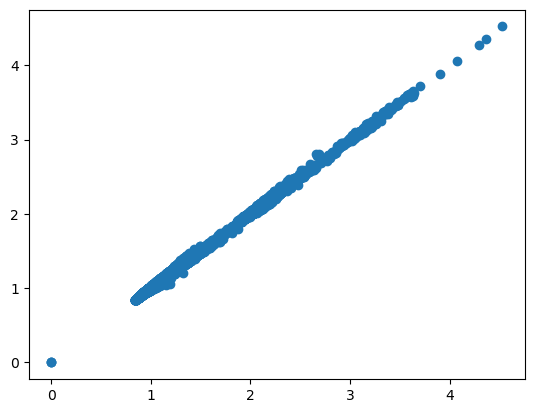

In [29]:
plt.scatter(q1['w'], q2['w'])